## Dataset Overview

We are working with the CMAPSS dataset, which simulates a fleet of jet engines operating under the **same operating conditions** and with **one type of fault mode**.

- `train_FD001.txt`: Engines run until failure (each engine has full history)
- `test_FD001.txt`: Engines are only partially observed
- `RUL_FD001.txt`: True Remaining Useful Life values for the engines in the test set

Each row in the train/test files corresponds to one cycle of one engine. The goal is to predict how many cycles are left (RUL) or whether failure is imminent.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [3]:
train_data = pd.read_csv("../../data/raw/train_FD001.txt", sep="\s+", header=None)
train_data.dropna(axis=1, how='all', inplace=True) # Drop columns with all NaN values
cols = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + [f'sensor_{i}' for i in range(1, 22)] # Column names
train_data.columns = cols

train_data.head()

,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


## Data Description
- `Couloumn 1`: Engine ID
- `Couloumn 2`: Cycle number
- `Couloumn 3-5`: 3 Operational settings 
- `Couloumn 6-21`: 21 Sensor 

Lets take a close look at when the engines fail. The engines are not all the same age when they fail, and they do not all fail at the same time. Some engines have a lot of cycles before failure, while others have very few. This is important to consider when building a predictive model.

In [4]:
# print cycle count for all units
print(train_data.groupby('unit')['cycle'].count())

unit
1      192
2      287
3      179
4      189
5      269
      ... 
96     336
97     202
98     156
99     185
100    200
Name: cycle, Length: 100, dtype: int64


We see there are 100 engines in total and they all fail at different times, unit 1 at 192 and unit 5 at 269 and so on. The engines are not all the same age when they fail, and they do not all fail at the same time. Some engines have a lot of cycles before failure, while others have very few. This is important to consider when building a predictive model and simulating real-world scenarios.

## RUL and Labeling Context

The Remaining Useful Life (RUL) is **not explicitly provided in the training set** but since each engine runs until failure, we can compute it by subtracting the current cycle from that engines maximum cycle.

For the test set, the RUL is provided separately in the file `RUL_FD001.txt`. It contains one value per engine, representing the number of cycles left **after the last recorded cycle** for each test engine. We will calculate RUL for training data and map the provided RUL values for the test set using their final cycle positions.


## Basic data validation

In [5]:
print("Null values in training set:", train_data.isnull().sum().sum())
print("Duplicate rows in training set:", train_data.duplicated().sum())
print("Unique engines in train:", train_data['unit'].nunique())
print("Max cycle in train:", train_data['cycle'].max())

Null values in training set: 0
Duplicate rows in training set: 0
Unique engines in train: 100
Max cycle in train: 362


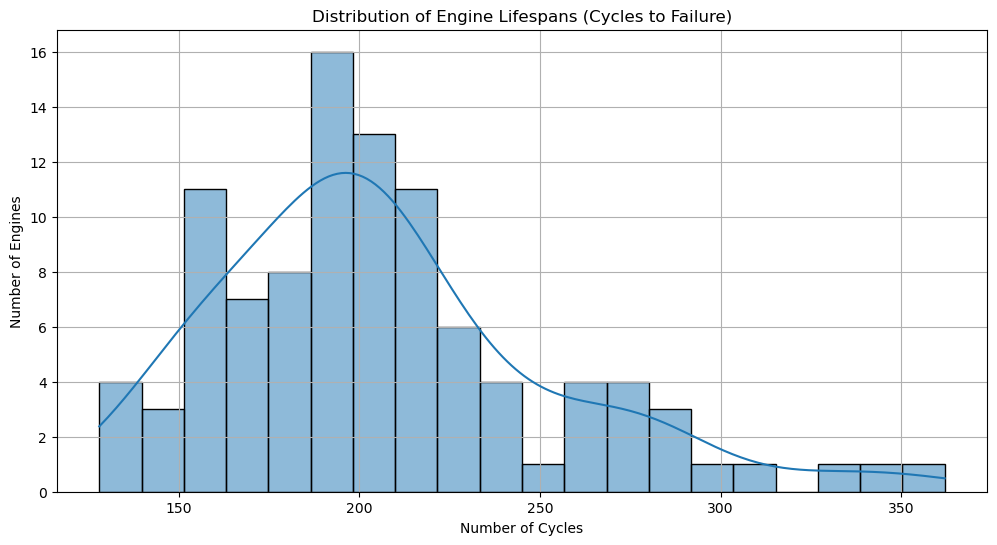

In [6]:
plt.figure(figsize=(12, 6))
cycle_lengths = train_data.groupby("unit")["cycle"].max()
sns.histplot(cycle_lengths, bins=20, kde=True)
plt.title("Distribution of Engine Lifespans (Cycles to Failure)")
plt.xlabel("Number of Cycles")
plt.ylabel("Number of Engines")
plt.grid(True)
plt.show()

The plot above shows the distribution of engine lifespans, measured by the number of cycles each engine ran before failure in the training set. Most engines fail between 170 and 220 cycles, with a small number surviving beyond 300 cycles.

This variation in failure timing is critical when building a predictive model. It highlights that failure is not purely time-driven but likely influenced by operating conditions and sensor behaviors. A well-performing model needs to learn patterns from sensors and not just rely on cycle count alone.

The long tail toward higher cycle counts also suggests we may want to normalize or engineer features that make relative time (e.g., “percentage to failure”) more meaningful.

Next, we’ll explore how sensor readings evolve over time to identify which ones reflect degradation.

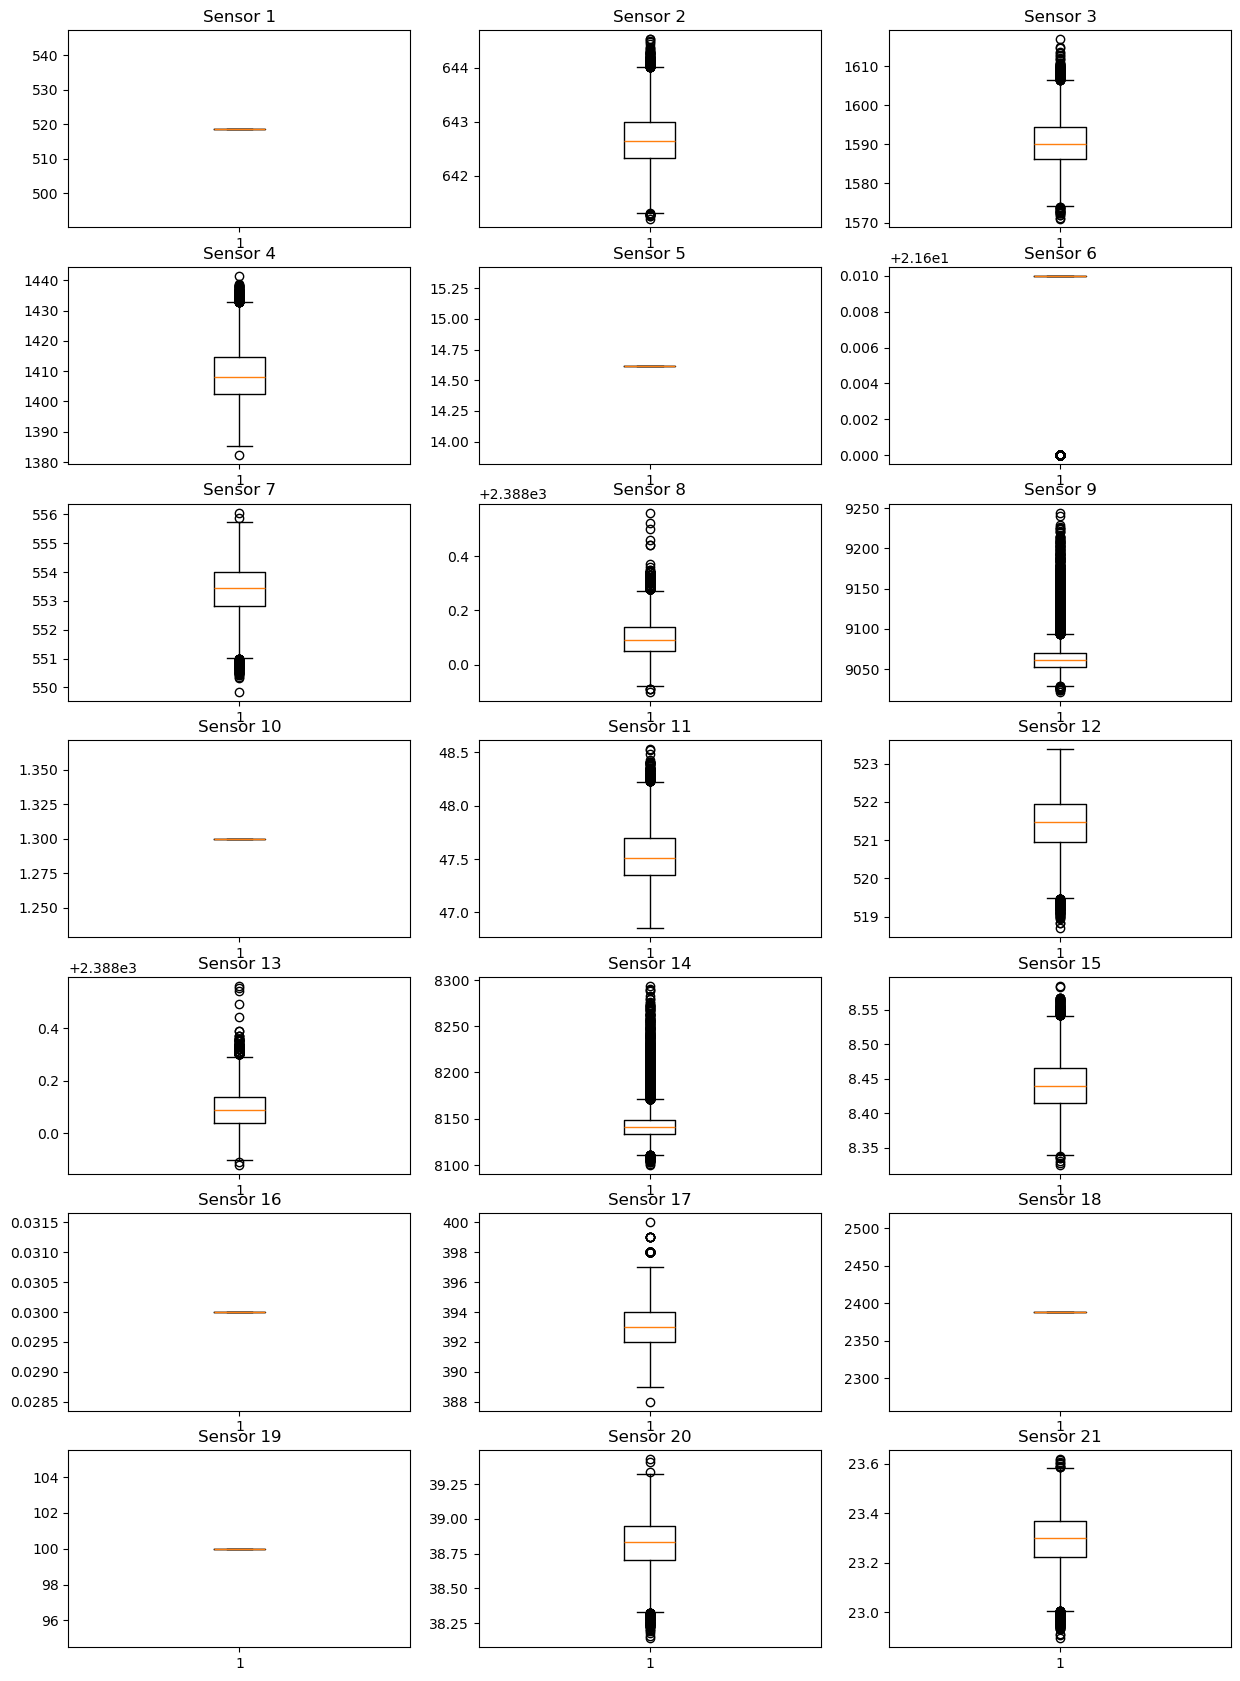

In [7]:
plt.figure(figsize = (15, 21))
for i in np.arange(5, 26):
    temp = train_data.iloc[:, i]
    plt.subplot(7,3, i-4)
    plt.boxplot(temp)
    plt.title("Sensor "+ str(i-4))
plt.show()

We see that sensor 1, 5, 6, 10, 16, 18 and 19 is a constant value. This means that these sensors are not providing any useful information. We can omit and drop these columns. Sensor 11 does not have a lot of deviation either we will take a closer look at this sensor later. The other sensors have a lot of variation and are likely to be useful for our model. We will keep all the sensors for now and see how they perform in the model.

Mean std across engines for sensor 11: 0.23744548858291575


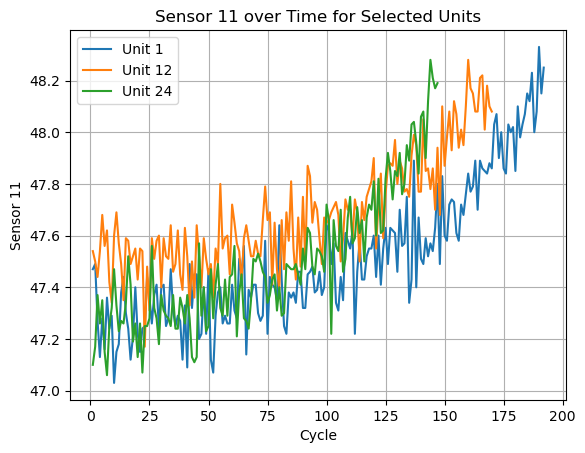

In [8]:
sensor_11_variation = train_data.groupby('unit')['sensor_11'].std()
print("Mean std across engines for sensor 11:", sensor_11_variation.mean())

# visualize a few
import matplotlib.pyplot as plt

for unit in [1, 12, 24]:
    subset = train_data[train_data['unit'] == unit]
    plt.plot(subset['cycle'], subset['sensor_11'], label=f"Unit {unit}")
plt.xlabel("Cycle")
plt.ylabel("Sensor 11")
plt.title("Sensor 11 over Time for Selected Units")
plt.legend()
plt.grid(True)
plt.show()


In [9]:
# Temporary RUL column
train_data['rul'] = train_data.groupby('unit')['cycle'].transform('max') - train_data['cycle']

X = train_data.drop(columns=['unit', 'cycle', 'rul'])
y = train_data['rul']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
rf = RandomForestRegressor(n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

# Check sensor_11 importance
importances = pd.Series(rf.feature_importances_, index=X.columns)
print("Sensor 11 importance:", importances['sensor_11'])


Sensor 11 importance: 0.40896973362997135


### Closer Look: Sensor 11

Although sensor 11 showed minimal variance in the boxplot, a closer inspection reveals that it steadily increases over time within individual engines.

- Mean standard deviation across engines: ~0.237
- Regression feature importance: **0.409**, one of the highest among all sensors

This suggests that while sensor 11 may look flat overall, it encodes a meaningful degradation signal over time, making it valuable for RUL prediction.

So that means sensor 11 is retained and all other constants are dropped.


In [ ]:
redundant_settings = ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
train_data.drop(columns=redundant_settings, inplace=True) # will give an error if you run this cell twice

## Compute RUL for Training Data

In [11]:
# Compute Remaining Useful Life (RUL) for training data
train_data['rul'] = train_data.groupby('unit')['cycle'].transform('max') - train_data['cycle']

# Quick check
print("RUL stats:\n", train_data['rul'].describe())
train_data[['unit', 'cycle', 'rul']].head()


RUL stats:
 count    20631.000000
mean       107.807862
std         68.880990
min          0.000000
25%         51.000000
50%        103.000000
75%        155.000000
max        361.000000
Name: rul, dtype: float64


,unit,cycle,rul
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


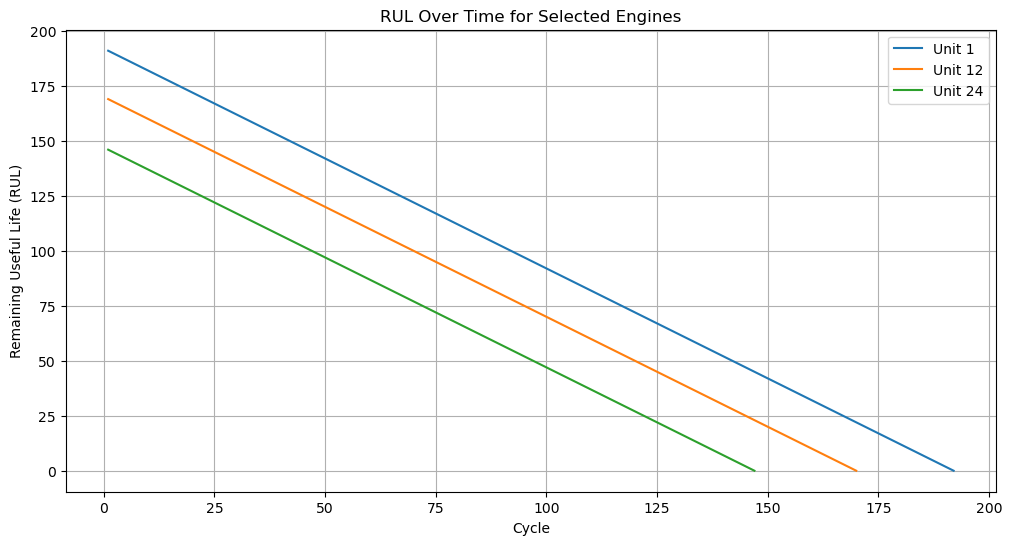

In [12]:
plt.figure(figsize=(12, 6))
for unit in [1, 12, 24]:
    subset = train_data[train_data['unit'] == unit]
    plt.plot(subset['cycle'], subset['rul'], label=f"Unit {unit}")

plt.title("RUL Over Time for Selected Engines")
plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life (RUL)")
plt.legend()
plt.grid(True)
plt.show()


## Prepare the test set

In [21]:
# Load test set
test_data = pd.read_csv("../../data/raw/test_FD001.txt", sep="\s+", header=None)
test_data.dropna(axis=1, how='all', inplace=True)
test_data.columns = ['unit', 'cycle'] + [f'op_setting_{i}' for i in range(1, 4)] + \
                    [f'sensor_{i}' for i in range(1, 22)]


# Load RUL file
rul_data = pd.read_csv("../../data/raw/RUL_FD001.txt", header=None, names=["final_rul"])

print("Test data prepared. Sample:")
test_data.head()


Test data prepared. Sample:


,unit,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


## Compare train and test data

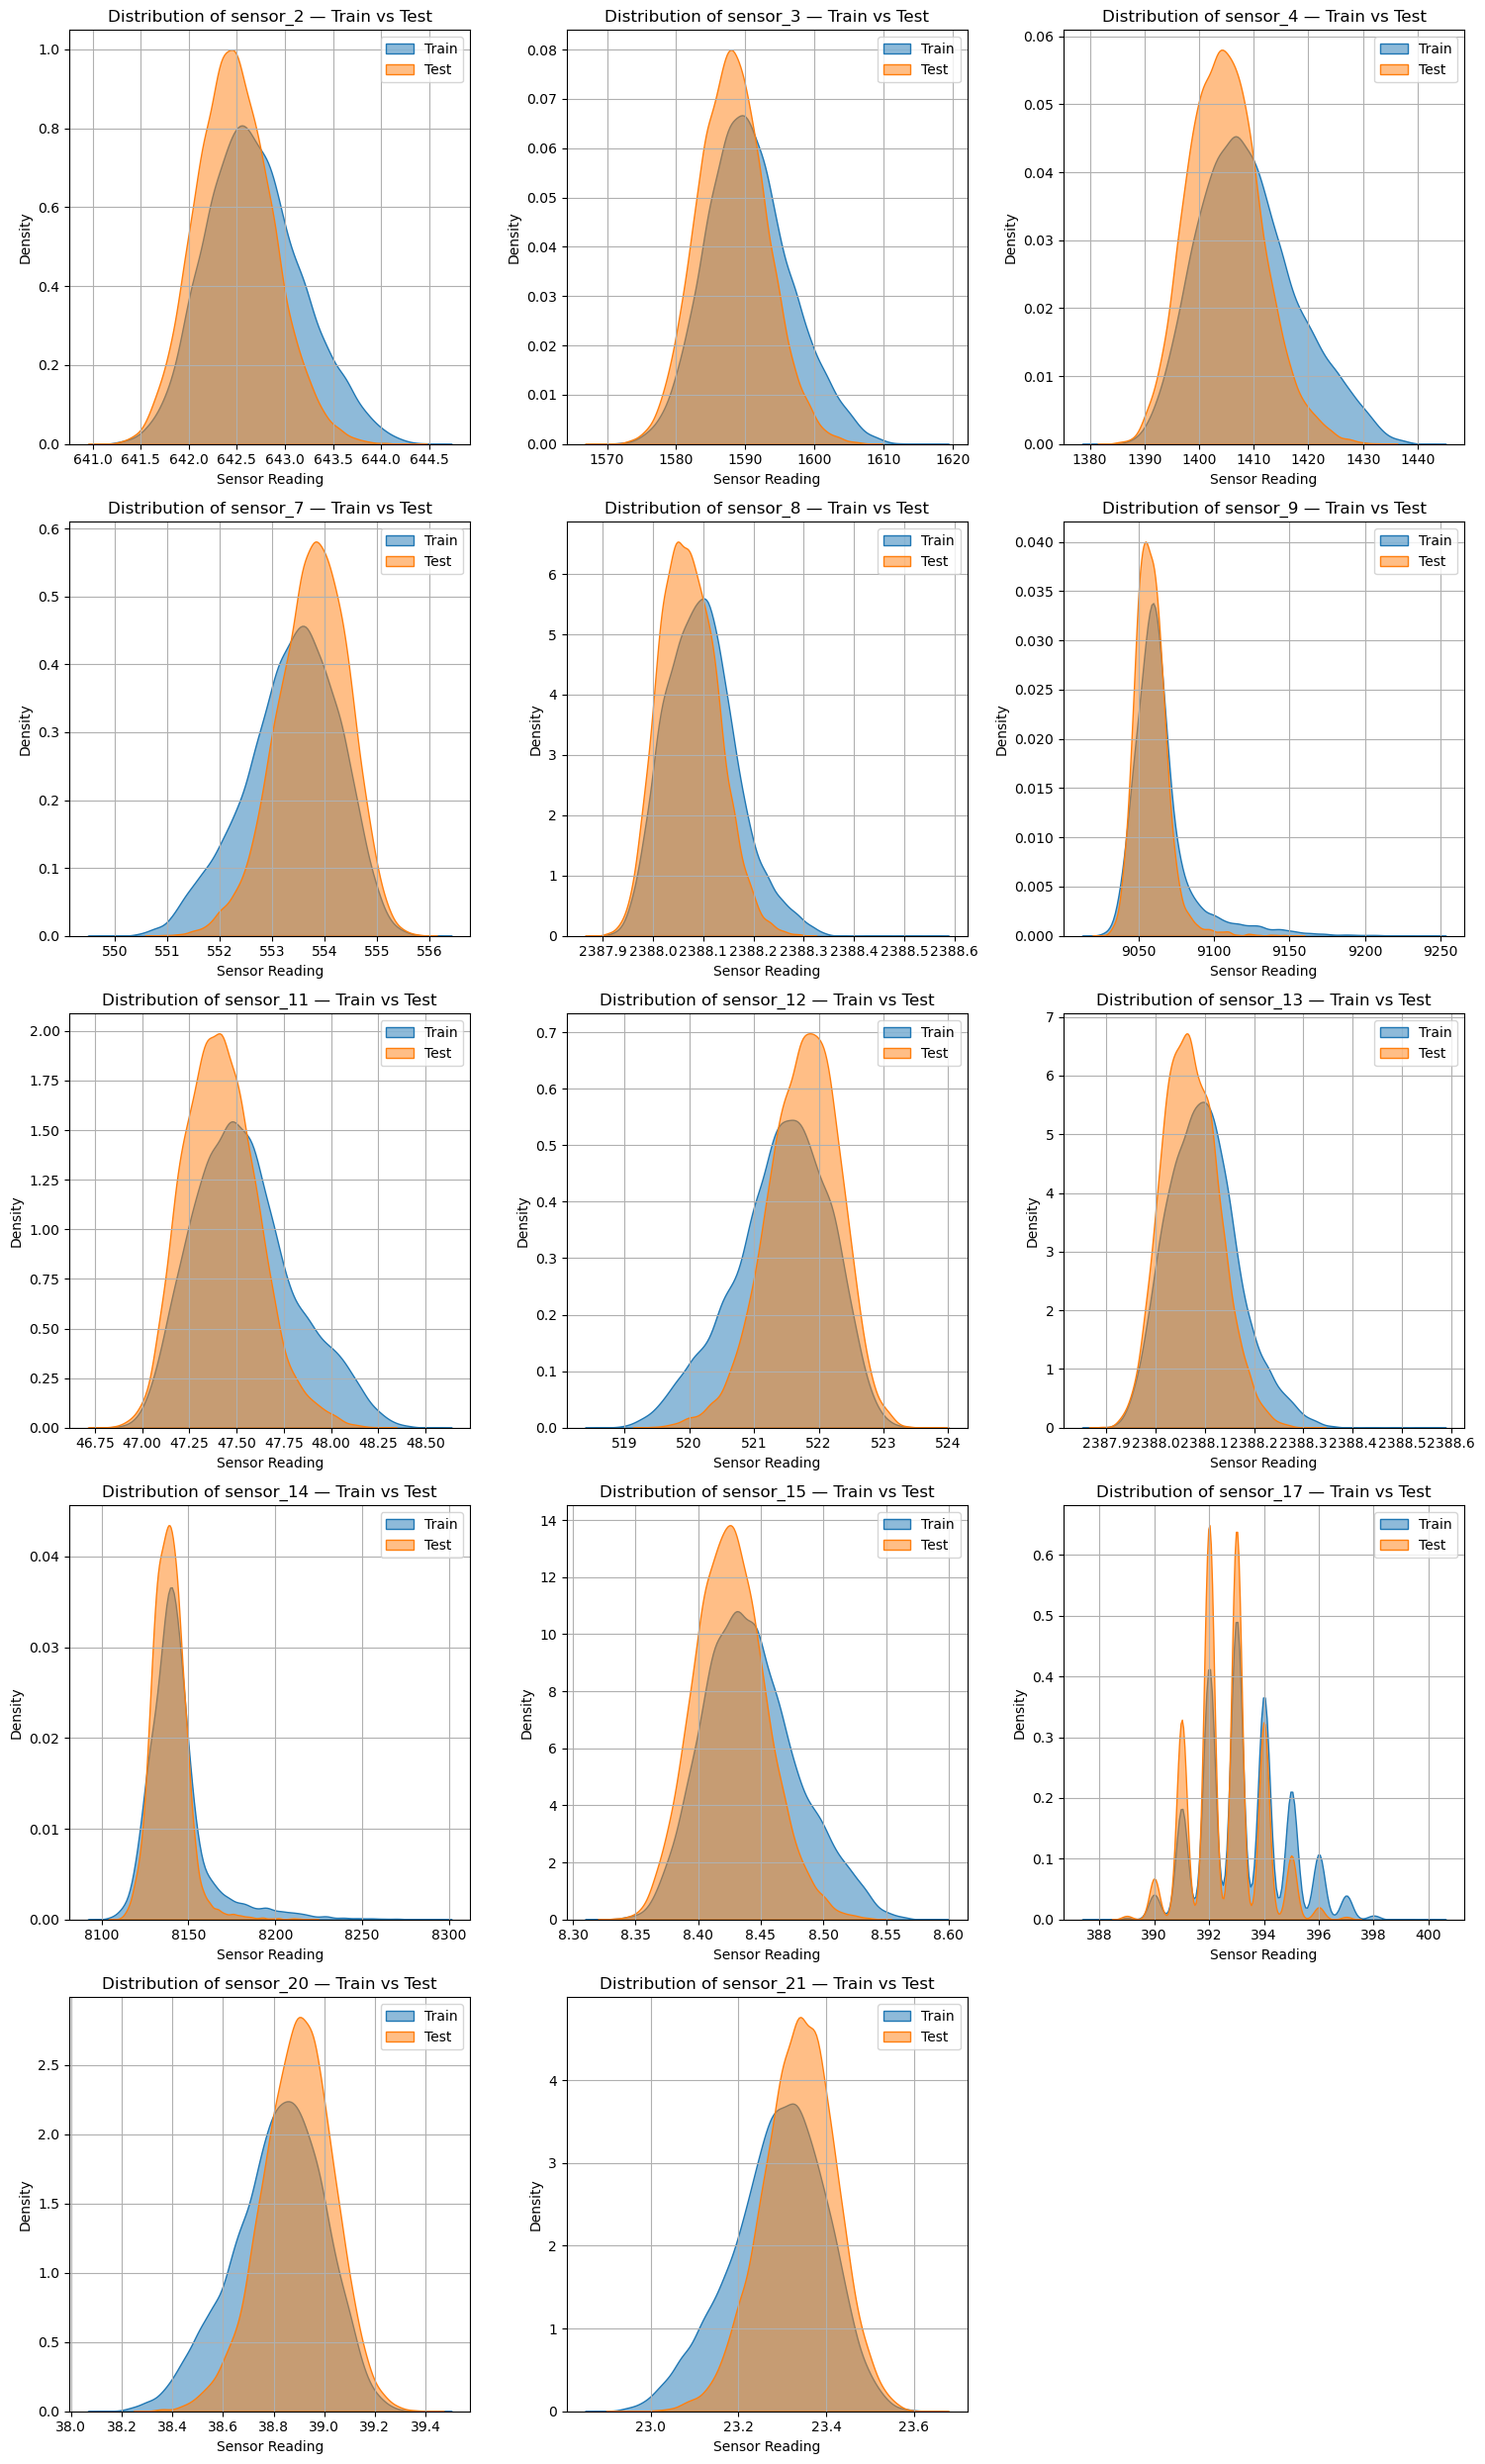

In [22]:
sensors_to_compare = ['sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21']

# Set up the grid for subplots
n_cols = 3
n_rows = (len(sensors_to_compare) + n_cols - 1) // n_cols  # Calculate rows needed
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))  # Adjust figure size

# Flatten axes for easy iteration
axes = axes.flatten()

for i, sensor in enumerate(sensors_to_compare):
    sns.kdeplot(train_data[sensor], label='Train', fill=True, alpha=0.5, ax=axes[i])
    sns.kdeplot(test_data[sensor], label='Test', fill=True, alpha=0.5, ax=axes[i])
    axes[i].set_title(f"Distribution of {sensor} — Train vs Test")
    axes[i].set_xlabel("Sensor Reading")
    axes[i].set_ylabel("Density")
    axes[i].legend()
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Sensor Distribution: Train vs Test

The plots above compare the distribution of sensor readings across the training and test datasets for all remaining sensors. Most sensors show very similar distributions, with only slight shifts in means or density curves. This is a strong indicator that the test set was drawn from the same underlying process as the training data, meaning our model is likely to generalize well.

Some subtle deviations (e.g., sensor_3, sensor_9, sensor_14) may indicate natural operational variation, but nothing here suggests a significant covariate shift that would invalidate the predictive assumptions.

Overall, the dataset appears stable and well-suited for model training and evaluation.


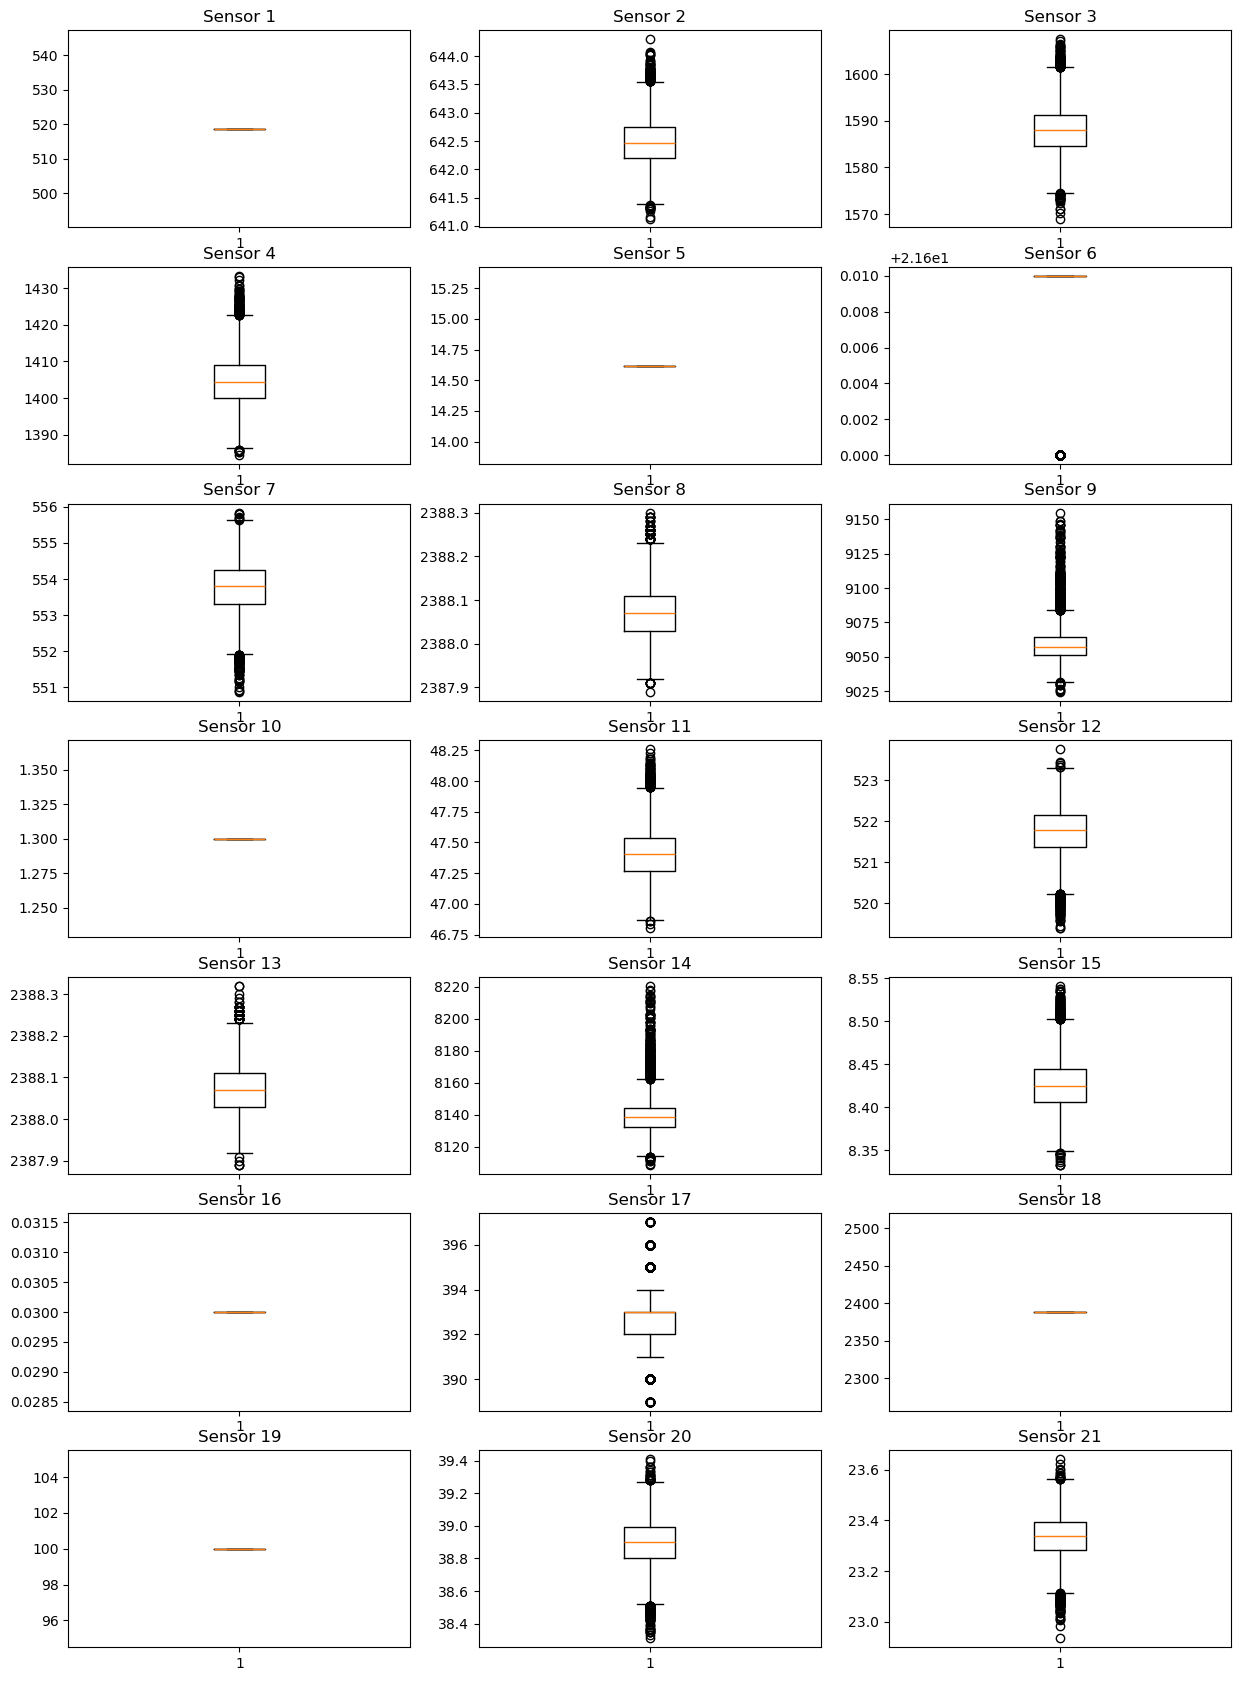

In [23]:
plt.figure(figsize = (15, 21))
for i in np.arange(5, 26):
    temp = test_data.iloc[:, i]
    plt.subplot(7,3, i-4)
    plt.boxplot(temp)
    plt.title("Sensor "+ str(i-4))
plt.show()

We can safely remove the same sensors from the test set as we did from the training set since they consist of constant values on both sets. We can finally save our train and test sets to CSV files for later use on model training and evaluation.

## Operating settings
Lets take a look if the operating settings are useful for our model. We can see that the operating settings are not constant and have a lot of variation except for operating settings 3. We can safely drop this column as well. The other operating settings have a lot of variation and are likely to be useful for our model. We will keep all the operating settings for now and see how they perform in the model.

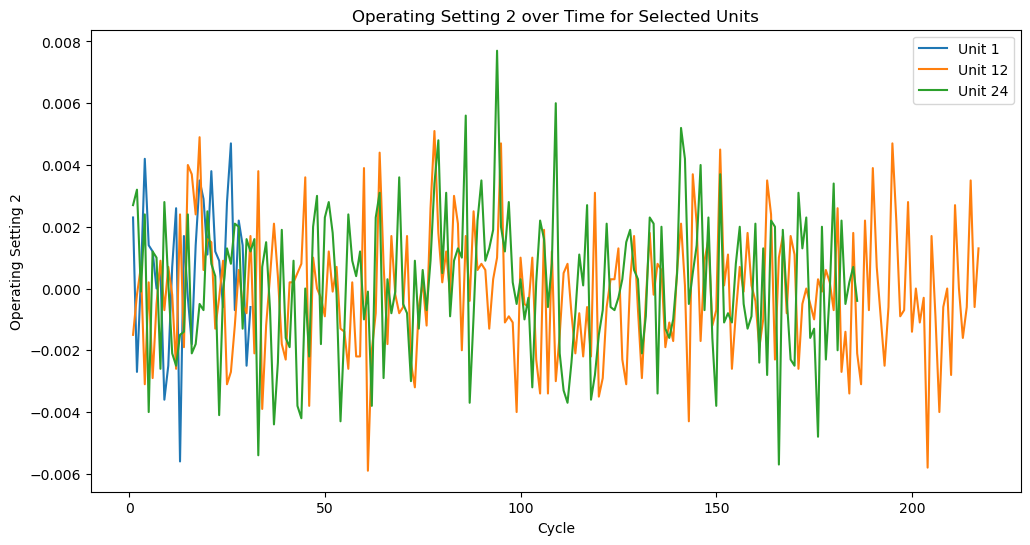

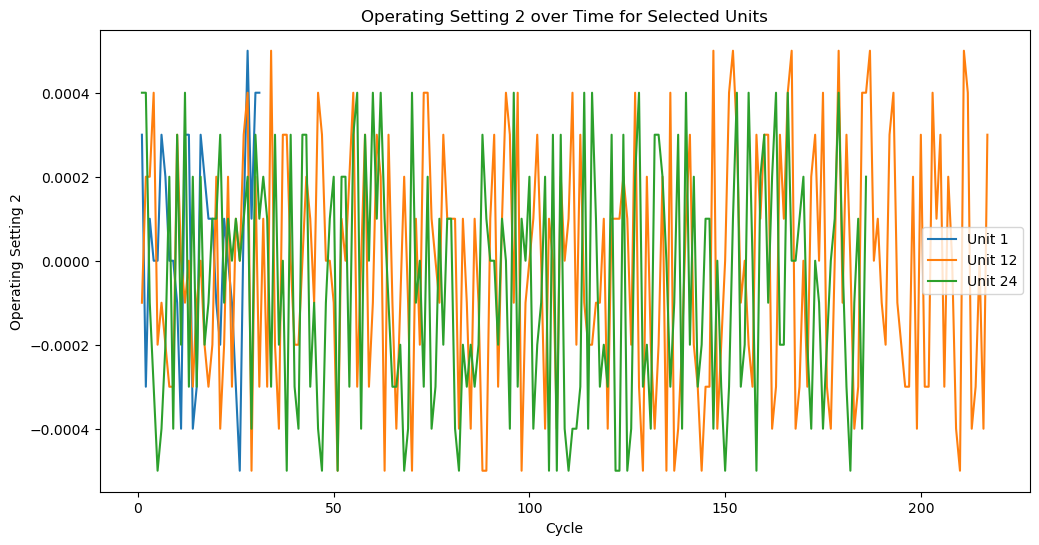

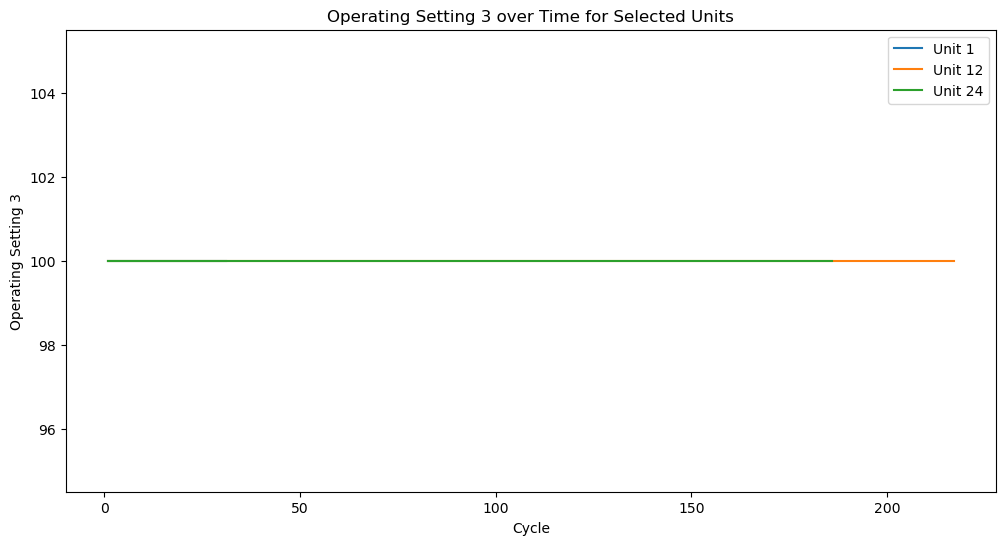

In [27]:
# plot operating settings
plt.figure(figsize=(12, 6))
for unit in [1, 12, 24]:
    subset = test_data[test_data['unit'] == unit]
    plt.plot(subset['cycle'], subset['op_setting_1'], label=f"Unit {unit}")
plt.xlabel("Cycle")
plt.ylabel("Operating Setting 2")
plt.title("Operating Setting 2 over Time for Selected Units")
plt.legend()

# operating setting 2
plt.figure(figsize=(12, 6))
for unit in [1, 12, 24]:
    subset = test_data[test_data['unit'] == unit]
    plt.plot(subset['cycle'], subset['op_setting_2'], label=f"Unit {unit}")
plt.xlabel("Cycle")
plt.ylabel("Operating Setting 2")
plt.title("Operating Setting 2 over Time for Selected Units")
plt.legend()

plt.figure(figsize=(12, 6))
for unit in [1, 12, 24]:
    subset = test_data[test_data['unit'] == unit]
    plt.plot(subset['cycle'], subset['op_setting_3'], label=f"Unit {unit}")
plt.xlabel("Cycle")
plt.ylabel("Operating Setting 3")
plt.title("Operating Setting 3 over Time for Selected Units")
plt.legend()

In [ ]:
redundant_settings = ['op_setting_3', 'sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']
test_data.drop(columns=[col for col in redundant_settings if col in test_data.columns], inplace=True)

# Save cleaned test set
test_data.to_csv("../../data/processed/test_FD001_preprocessed.csv", index=False)
train_data.to_csv("../../data/processed/train_FD001_preprocessed.csv", index=False)
